# Hypothesis tests and confidence intervals

We often measure associations between input and output variables. The strength of our observed associations can be noisy. Let's quantify this noisiness and assess the appropriate degree of confidence in our results. We'll do this via hyopthesis tests and confidence intervals.

You learned about hypothesis tests and confidence intervals in your stats class. Today, we'll re-examine them from the perspective of data scientists with a lot of computational power at our disposal. That is, we'll show how the analytical results you learned in stats can be approximated (sometimes, improved!) by simulations that help us understand the principles involved.

Here's a cheat sheet of our methods:

|Name|Procedure|Question|
|---|---|---|
|Train/test split, cross-validation|Pretend we don't know about part of the data|Does a pattern we observe in one part of the data hold for the other part?|
|Permutation test|Shuffle the outputs|Is the pattern we observe outside the range of values we might reasonably expect to get by chance?|
|Bootstrap test|Sample with replacement|Is the pattern we observe robust? What range of values might be plausible?|

In [1]:
# imports and setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.linear_model import LinearRegression, LogisticRegression
from   sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (12.0, 8.0)

## Synthetic data

Create a small dataset with known relation between *x* and *y*, but also with a moderate amount of random noise.

In [2]:
real_slope = 0.3 # we will measure this; our estimand
sample_size = 20

real_x = np.random.normal(0,1, size=sample_size)  # mean 0, variance 1
noise = np.random.normal(0,0.5, size=sample_size) # mean 0, variance 0.5
real_y = real_x * real_slope  +  noise # no constant, hence true intercept is zero

df = pd.DataFrame({"x": real_x, "y": real_y})

display(df)
print("x mean observed:", df.x.mean())
print("y mean observed:", df.y.mean())

,x,y
0,3.082662,0.528875
1,0.515762,-0.831681
2,-1.312256,-0.697619
3,0.019855,-0.255199
4,-0.753977,-0.048439
5,0.973297,0.718122
6,0.203712,-0.143490
7,0.296279,-0.081774
8,1.869643,0.282855
9,-0.814613,-0.266060


x mean observed: 0.2919925737116863
y mean observed: -0.03411689341861022


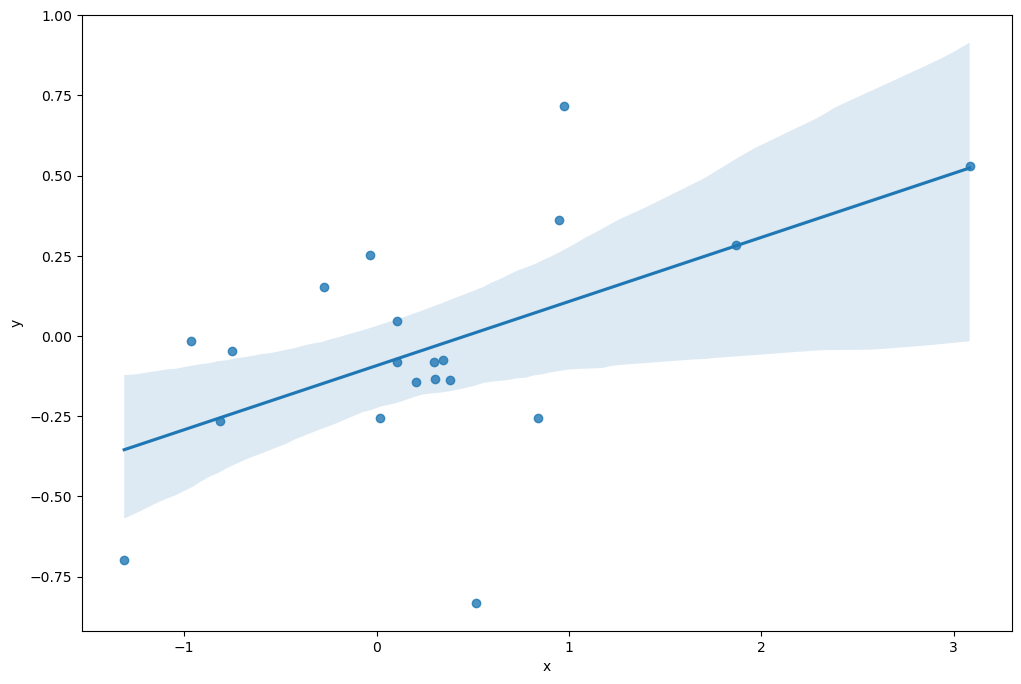

In [3]:
# plot synthetic data
sns.regplot(x='x', y='y', data=df);

In [4]:
model = LinearRegression().fit(df[["x"]], df["y"])
print(f'Observed slope: {model.coef_[0]:.3f} (true slope = {real_slope})')

Observed slope: 0.200 (true slope = 0.3)


Observed slope not exactly equal to specified slope, because noise is ... noisy.

## Two classic statistical measures

### *p* values and confidence intervals

Examine the analytical output from `statmodels.ols` fit to observed data. Focus on the second "block" of the output, where we see the values for the intercept and the coefficient of `x`, as well as *p* values and confidence intervals.

In [5]:
# use statsmodels to produce the type of statistical report you may have seen before
sm_model = smf.ols("y ~ x", data=df)
result = sm_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     7.461
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0137
Time:                        14:14:11   Log-Likelihood:                -4.2430
No. Observations:                  20   AIC:                             12.49
Df Residuals:                      18   BIC:                             14.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0925      0.074     -1.255      0.225      -0.247       0.062
x              0.1999      0.073      2.731      0.014       0.046       0.354
==============================================================================
Omnibus:                        5.198   Durbin-Watson:                   1.338
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                2.980
Skew:                          -0.619   Prob(JB):                        0.225
Kurtosis:                       4.429   Cond. No.                         1.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Argh, what do the key terms *mean*?
* What does a ***p*-value** mean?

> The probability that, absent any link between predictor and output variables, but given the observed variation in the data, an effect (or relationship) as large or larger than the observed effect would be measured.

* What is a **confidence interval**?

> A confidence interval represents the range of output estimates that are not significantly different from the measured value at the *p* < *x* level.

## Permutation tests -> *p* values

Experiments in the real world are hard and expensive. Can we find ways to use our existing data to simulate experimental results without performing more experiments?

Can we simulate the null hypothesis? If so, we can calculate a *p*-value just by running a bunch of simulated experiments and seeing how often we observe a result as large or larger than the one we saw in the true data.

Recall that a **null hypothesis** is a hypothesis that there is no relationship between two variables, or no difference between two sets of observations, etc. Our task now is to find a way to see what our data would do under a null hypothesis. In the present case, a suitable null hypothesis would be that there is no relationship between `x` and `y`. If this were true, we would expect the observed slope of the line of best fit between those variables to be zero.

One method to simulate this null hypotheis in our data is to shuffle the output values, so that there's no association between inputs and outputs. Let's write a function to implement this.

In [6]:
def permute(input_array):
    # shuffle is inplace, so copy to preserve input
    permuted = input_array.copy().values #convert to numpy array, avoiding warning
    np.random.shuffle(permuted)
    return pd.Series(permuted) # convert back to pandas

In [7]:
df['y']

0     0.528875
1    -0.831681
2    -0.697619
3    -0.255199
4    -0.048439
5     0.718122
6    -0.143490
7    -0.081774
8     0.282855
9    -0.266060
10   -0.136581
11   -0.256134
12   -0.017027
13    0.152311
14   -0.082176
15   -0.134578
16   -0.074709
17    0.045373
18    0.362785
19    0.252807
Name: y, dtype: float64

In [8]:
permute(df['y'])

0     0.252807
1     0.718122
2    -0.143490
3     0.045373
4    -0.082176
5    -0.134578
6    -0.256134
7    -0.266060
8    -0.255199
9    -0.081774
10   -0.697619
11    0.362785
12    0.282855
13   -0.831681
14   -0.074709
15   -0.017027
16    0.528875
17    0.152311
18   -0.136581
19   -0.048439
dtype: float64

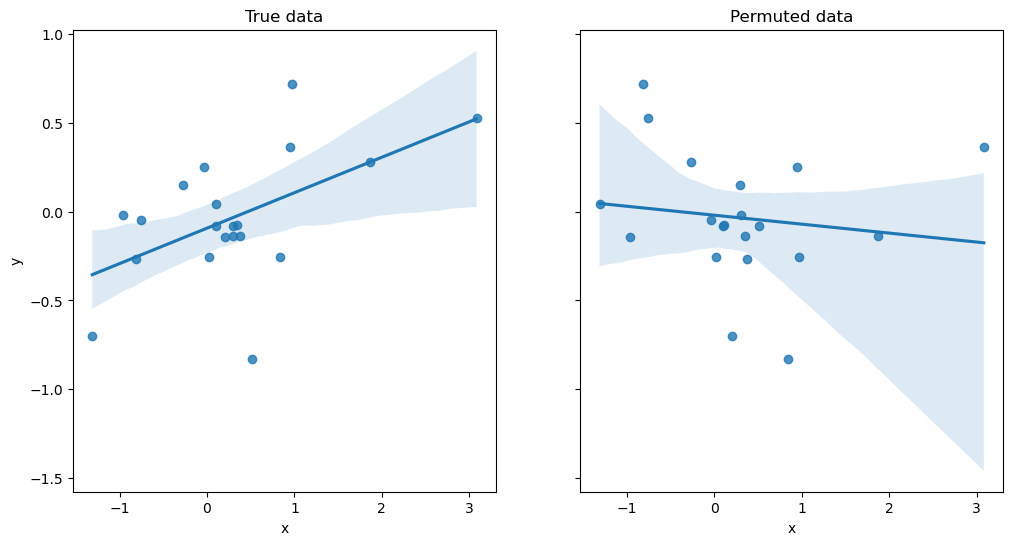

In [9]:
# plot one instance of permuted data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
sns.regplot(x=df.x, y=df.y, ax=ax1)
ax1.set_title('True data')
sns.regplot(x=df.x, y=permute(df.y), ax=ax2)
ax2.set_title('Permuted data')
plt.show()

Now, if we permute our `y` data and fit a linear model to it, we'll have the result of a trial under the null hypothesis (that there is no relationship between `x` and `y`). We *know* that there's no relatioship because we shuffled the `y` randomly, breaking any possible conection to `x`!

Let's visualize the results of a bunch of permutations, with associated linear models:

In [10]:
def plot_model_line(df, model, is_resampled=True):
    '''
    Takes a dataframe and a fitted model
    Plots a line of best fit to the data
    '''
    if is_resampled:
        color="grey"
        alpha=0.1
    else:
        color="steelblue"
        alpha=0.7
    plt.plot(df['x'], df['x'] * model.coef_[0] + model.intercept_, color=color, alpha=alpha)

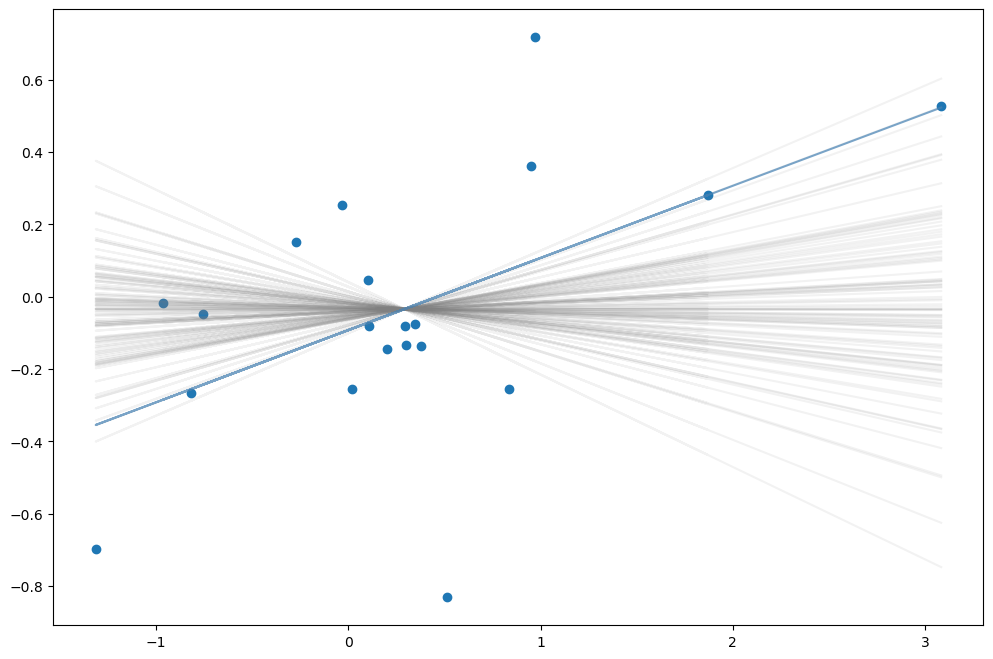

In [11]:
# plot true data
plt.scatter(df['x'], df['y'])

# plot 100 iterations of models on permuted data
for i in range(100):
    permuted_model = LinearRegression().fit(df[["x"]], permute(df['y']))
    plot_model_line(df, permuted_model)

# model true data and plot
model = LinearRegression().fit(df[["x"]], df["y"])
plot_model_line(df, model, is_resampled=False)
    
plt.show()

In [12]:
# what's up with the point of convergence in all the models?
print(df.x.mean(), df.y.mean())

0.2919925737116863 -0.03411689341861022


In [13]:
# what fraction of permuted (null hyopthesis) slopes are greater than our observed slope?
steeper_slopes = 0
n_permutations = 1000
permuted_slopes = np.zeros(n_permutations) # preallocate array of correct size

for i in range(n_permutations):
    permuted_model = LinearRegression().fit(df[['x']], permute(df.y))
    
    permuted_slopes[i] = permuted_model.coef_[0]
    
    if np.abs(permuted_model.coef_[0]) > np.abs(model.coef_):
        steeper_slopes += 1
    
print(f'Fraction of permuted slopes more extreme than observed slopes: {steeper_slopes / n_permutations}')

Fraction of permuted slopes more extreme than observed slopes: 0.009


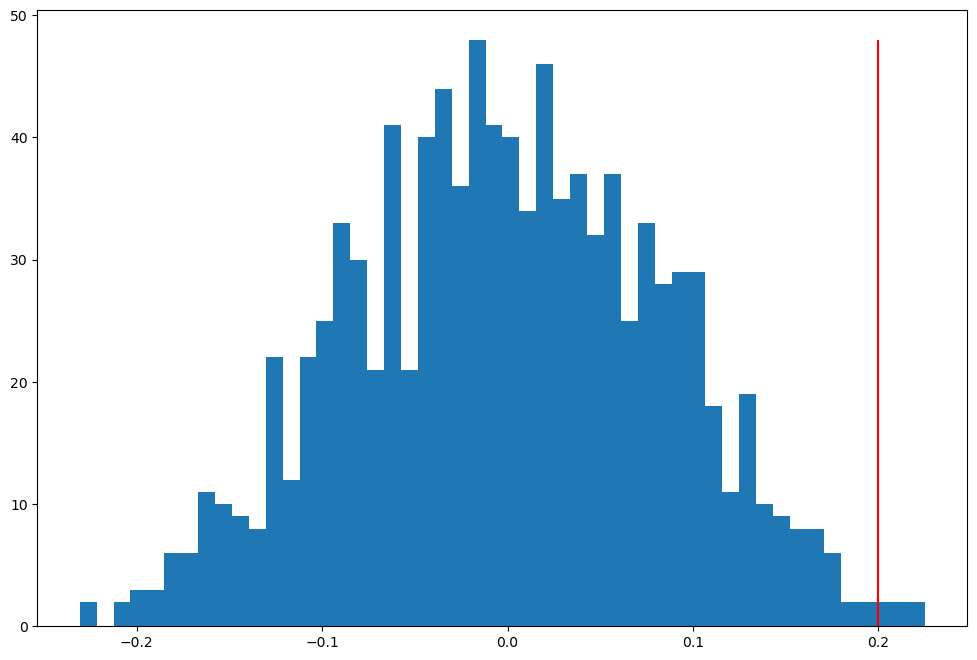

In [14]:
# plot where our observed slope falls in the distribution 
#  of slopes under the null hypothesis
binsizes, _, _ = plt.hist(permuted_slopes, bins=50)
plt.vlines(model.coef_[0], ymin=0, ymax=np.max(binsizes), color='red')
plt.show()

In [15]:
# compare simulated probability of observing a slope this great or greater
#  to analytic p-value
print('Analytic p (slope): ', result.pvalues.x)
print('Simulated p (slope):', steeper_slopes / n_permutations)

Analytic p (slope):  0.01370246319867939
Simulated p (slope): 0.009


## Bootstrap resampling -> confidence intervals

OK, so we can calulate a *p*-value experimentally by simulated repeated trials under the null hypothesis and observing the results.

But null trials are ... boring? What if we wanted to perform our *actual* experiment over and over again to see the range of values we might measure. This is interesting, but it's hard and expensive (or impossible)!

Can we simulate a bunch of trials using data that are fundamentally like our existing data, but differ from it in ways that reflect the range of realistic possibilities?

Here, we want the **bootstrap method**. We resample our existing data *with replacement*. Each resampled dataset will be similar to our existing data, but it might oversample some points and leave others out entirely. Do this enough times, and we have a sense of what our data might have looked like, had it been sampled differently from the same population.

In [16]:
# sample with replacement in pandas
df.sample(n=len(df), replace=True)

,x,y
2,-1.312256,-0.697619
11,0.837900,-0.256134
9,-0.814613,-0.266060
1,0.515762,-0.831681
19,-0.033239,0.252807
13,-0.271132,0.152311
11,0.837900,-0.256134
10,0.379796,-0.136581
16,0.347685,-0.074709
0,3.082662,0.528875


In [17]:
# means will change, unlike permutation
print('original data')
display(df.mean())

print('\nresampled data')
display(df.sample(n=len(df), replace=True).mean())

original data


x    0.291993
y   -0.034117
dtype: float64


resampled data


x    0.669382
y   -0.021151
dtype: float64

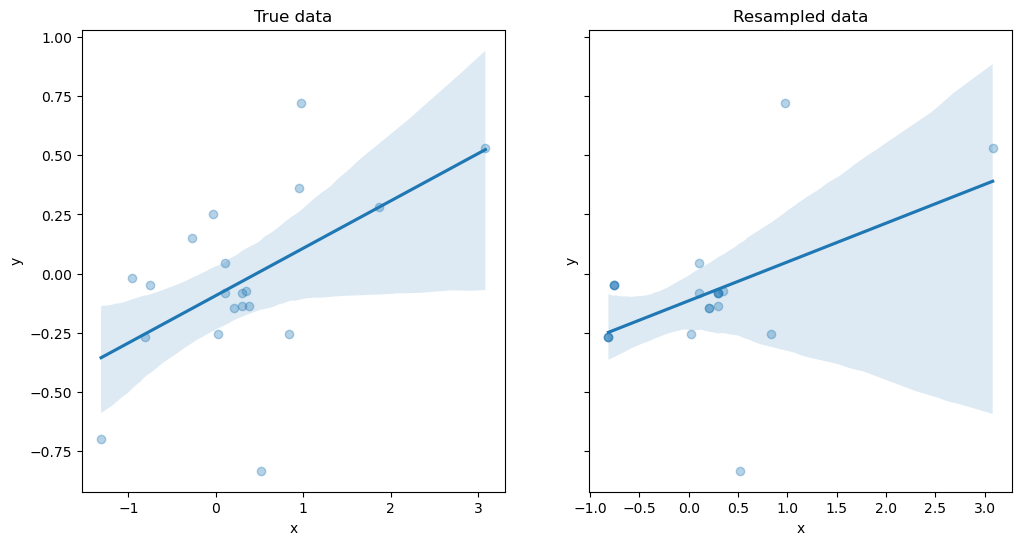

In [18]:
# plot one instance of resampled data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
sns.regplot(x=df.x, y=df.y, scatter_kws={'alpha':0.33}, ax=ax1)
ax1.set_title('True data')
sns.regplot(
    x='x', 
    y='y', 
    data=df.sample(n=len(df), replace=True), 
    scatter_kws={'alpha':0.33}, 
    ax=ax2
)
ax2.set_title('Resampled data')
plt.show()

Unlike the permuted data, there is **not** exactly one instance of each true *y* value and we have **not** broken the association between individual *x* and *y* observations). But some pairs of observations are missing and some are present more than once in the resampled data.

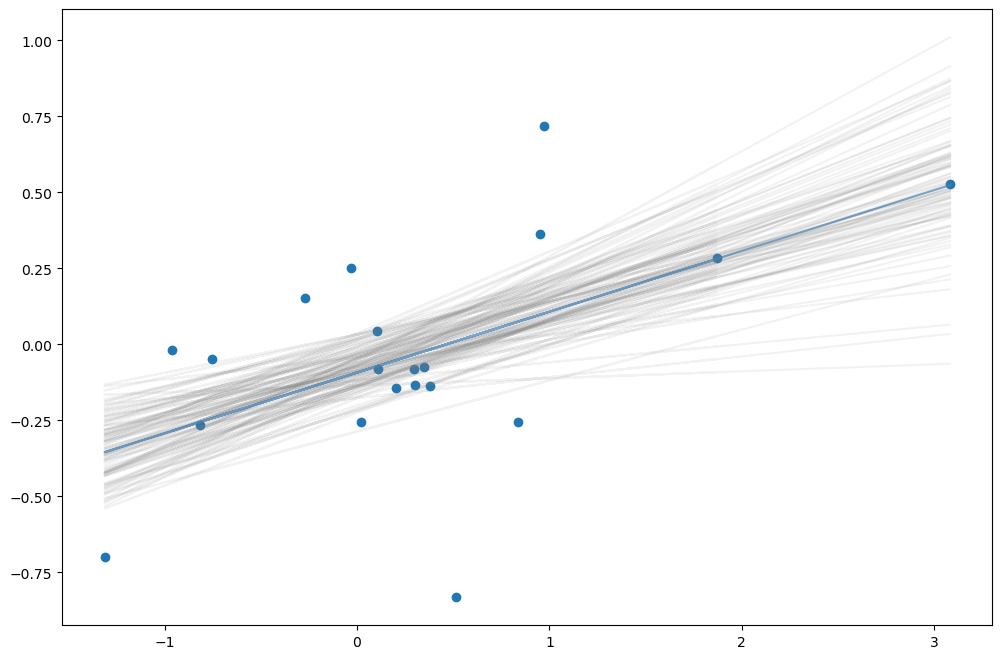

In [19]:
# a bunch of resamplings
# plot true data
plt.scatter(df['x'], df['y'])

# plot 100 iterations of models on resampled data
for i in range(100):
    resampled_data = df.sample(n=len(df), replace=True)
    resampled_model = LinearRegression().fit(resampled_data[["x"]], resampled_data['y'])
    plot_model_line(df, resampled_model)

# model true data and plot
model = LinearRegression().fit(df[["x"]], df["y"])
plot_model_line(df, model, is_resampled=False)
    
plt.show()

In [20]:
# run a whole lot of bootstraps
n_bootstrap = 1000
bootstrap_slopes = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    resampled_data = df.sample(n=len(df), replace=True)
    resampled_model = LinearRegression().fit(resampled_data[["x"]], resampled_data["y"])
    
    bootstrap_slopes[i] = resampled_model.coef_[0]

In [21]:
# get largest 2.5% and smallest 2.5% of modeled slopes
print(np.quantile(bootstrap_slopes, q=[0.025, 0.975]))

[0.04224076 0.32445308]


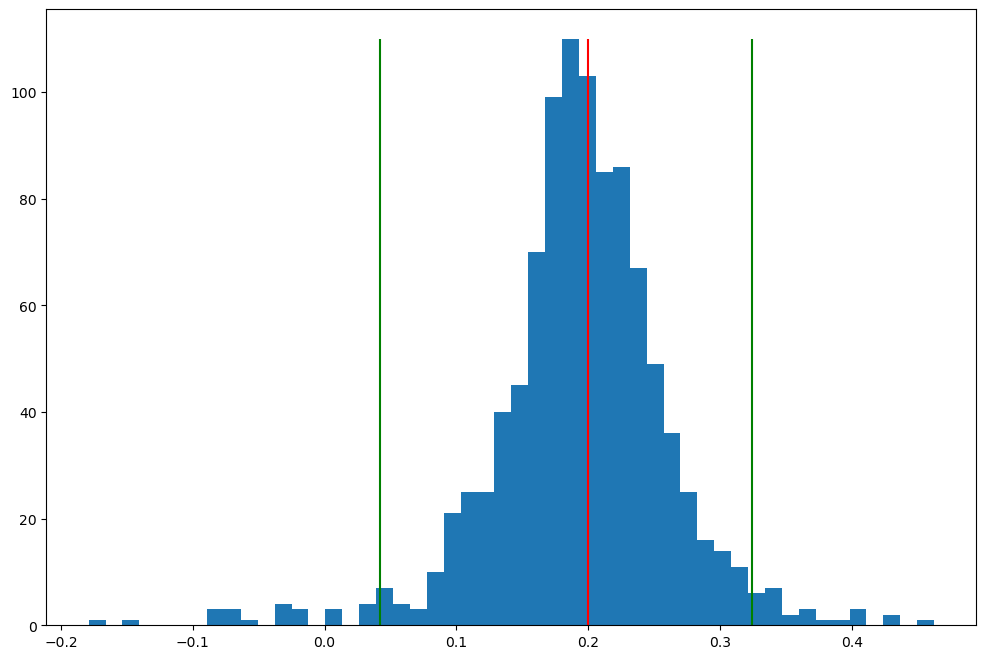

In [22]:
# plot observed slope and histogram of resampled slopes
binsizes, _, _ = plt.hist(bootstrap_slopes, bins=50)
plt.vlines(model.coef_[0], ymin=0, ymax=np.max(binsizes), color='red')
plt.vlines(np.quantile(bootstrap_slopes, q=[0.025])[0], ymin=0, ymax=np.max(binsizes), color='green')
plt.vlines(np.quantile(bootstrap_slopes, q=[0.975])[0], ymin=0, ymax=np.max(binsizes), color='green')
plt.show()

In [23]:
# compare analytical CI to simulated CI
smf_ci = result.conf_int(0.05).loc['x']
simulated_ci = np.quantile(bootstrap_slopes, q=[0.025, 0.975])
print(f'Analytic CI (slope):  {smf_ci[0]:.3f}, {smf_ci[1]:.3f}')
print(f'Simulated CI (slope): {simulated_ci[0]:.3f}, {simulated_ci[1]:.3f}')

Analytic CI (slope):  0.046, 0.354
Simulated CI (slope): 0.042, 0.324
